In [57]:
import numpy as np
import matplotlib.pyplot as plt 

%matplotlib inline

In [58]:
def tilde(x):
    return np.array([
        [0, -x[2], x[1]],
        [x[2], 0, -x[0]],
        [-x[1], x[0], 0]
    ])

In [59]:
norm = np.linalg.norm
def mrp_sum(g1, g2):
    
    norm1 = norm(g1)
    norm2 = norm(g2)
    
    g_sum = ((1-norm1**2)*g2 +(1-norm2**2)*g1 - 2*np.cross(g1, g2)) / (1 + norm1**2 * norm2**2 - 2 * np.dot(g1, g2))
    return g_sum


def mrp_to_dcm(mrp):
    
    identity = np.identity(3)
    mrp_cross_matrix = tilde(mrp)
    norm_mrp = norm(mrp)
    dcm = identity + (8 * mrp_cross_matrix @ mrp_cross_matrix - 4 * (1 - norm_mrp ** 2) * mrp_cross_matrix) / \
                     ((1 + norm_mrp ** 2) ** 2)
    return dcm

def b_matrix_mrp(mrp):
    return (1-norm(mrp)**2)*np.identity(3) + 2*tilde(mrp) + 2 * np.outer(mrp, mrp)

def tilde(x):
    return np.array([
        [0, -x[2], x[1]],
        [x[2], 0, -x[0]],
        [-x[1], x[0], 0]])

def mrp_subtract(mrp1, mrp2):
    
    norm1 = norm(mrp1)
    norm2 = norm(mrp2)
    
    num = (1 - norm2**2)*norm1 - (1-norm1**2)*norm2 + 2*np.cross(mrp1, mrp2)
    denom = 1 + (norm1*norm2)**2 + 2*np.dot(mrp1, mrp2)
    
    result = num/denom
    result_norm = norm(result)
    if result_norm >= 1:
        result = -result/result_norm**2
        
    return result
    
    
def dcm2euler_param(dcm):
    
    trace = np.trace(dcm)
    b02 = 0.25 * (1 + trace)
    b12 = 0.25 * (1 + 2*dcm[0][0] - trace)
    b22 = 0.25 * (1 + 2*dcm[1][1] - trace)
    b32 = 0.25 * (1 + 2*dcm[2][2] - trace)
    
    if b02 == max(b02, b12, b22, b32):
        b0 = np.sqrt(b02)
        b1 = (dcm[1][2]-dcm[2][1]) / (4 * b0)
        b2 = (dcm[2][0]-dcm[0][2]) / (4 * b0)
        b3 = (dcm[0][1]-dcm[1][2]) / (4 * b0)
        return np.array([b0, b1, b2, b3])
    
    if b12 == max(b02, b12, b22, b32):
        b1 = np.sqrt(b12)
        b0 = (dcm[1][2]-dcm[2][1]) / (4 * b1)
        b2 = (dcm[0][1]+dcm[1][0]) / (4 * b1)
        b3 = (dcm[2][0]+dcm[0][2]) / (4 * b1)
        return np.array([b0, b1, b2, b3])
    
    if b22 == max(b02, b12, b22, b32):
        b2 = np.sqrt(b22)
        b1 = (dcm[0][1]+dcm[1][0]) / (4 * b2)
        b0 = (dcm[2][0]-dcm[0][2]) / (4 * b2)
        b3 = (dcm[1][2]+dcm[2][1]) / (4 * b2)
        return np.array([b0, b1, b2, b3])
    else:
        b3 = np.sqrt(b32)
        b1 = (dcm[2][0]+dcm[0][2]) / (4 * b3)
        b2 = (dcm[1][2]+dcm[2][1]) / (4 * b3)
        b0 = (dcm[0][1]-dcm[1][2]) / (4 * b3)
        return np.array([b0, b1, b2, b3])

def dcm2mrp(dcm):
    if np.isclose(np.trace(dcm), -1.0):
        quat = dcm2euler_param(dcm)
        sigma = quat[1:] / (1 + quat[0])
        return sigma
    trace_term = (np.trace(dcm) + 1)**0.5
    denom = (trace_term*(trace_term+2))
    num = np.array([
        dcm[1][2] - dcm[2][1],
        dcm[2][0] - dcm[0][2],
        dcm[0][1] - dcm[1][0]
    ])
    return num/denom

In [60]:

def sigma_rn(t):
    f = 0.03
    return np.array([
        0.1 * np.sin(f*t), 0.2 * np.cos(f*t), -0.3 * np.sin(2*f*t)
    ])
    
def sigma_rn_dot(t):
    f = 0.03
    return f * np.array([
        0.1 * np.cos(f*t), 0.2 * np.sin(f*t), -0.6 * np.cos(2*f*t)])


def omega_rn_func(t):
    mrp_rn = sigma_rn(t)
    mrp_rn_norm = norm(mrp_rn)
    # print(mrp_rn)
    b_matrix_rn = b_matrix_mrp(mrp_rn)
    b_matrix_rn_inv = b_matrix_rn.T / (1 + mrp_rn_norm**2)
    omega_rn = 4 * b_matrix_rn_inv @ sigma_rn_dot(t)
    return omega_rn

def omega_rn_dot_func(t, dt):
    
    omega_rn_1 = omega_rn_func(t)
    omega_rn_2 = omega_rn_func(t + dt)
    omega_rn_dot = (omega_rn_2 - omega_rn_1) / dt
    return omega_rn_dot

## Control Law

In [62]:
from numpy import sin, cos
def gimbal_frame_b(gamma, gamma_0, gs0, gt0):
    dg = gamma - gamma_0
    gs = cos(dg)*gs0 + sin(dg)*gt0
    gt = cos(dg)*gt0 - sin(dg)*gs0
    gg = np.cross(gs,gt)
    return gs, gt, gg


In [117]:
np.diag(np.array([
    [1,2,3],
    [4,5,6],
    [7,8,9]]))

array([1, 5, 9])

In [130]:
def runge_kutta45(f, x, t, h, **kwargs):
    """RK 45 method for numerical integration

    Args:
        f (_type_): function to calculate next state
        x (_type_): current state
        t (_type_): current time
        h (_type_): time step

    Returns:
        _type_: next state
    """
    k1 = h * f(x, t, **kwargs)
    k2 = h * f(x + k1/2, t + h/2, **kwargs)
    k3 = h * f(x + k2/2, t + h/2, **kwargs)    
    k4 = h * f(x + k3, t + h, **kwargs)    
    return x + 1/6*(k1 + 2*k2 + 2*k3 + k4)

def wheel_acceleration(gimbal_rate, omega_t, gs, omega_bn_dt, i_ws, u_s):
    return u_s/i_ws - gimbal_rate*omega_t - np.dot(gs, omega_bn_dt)

def gimbal_acceleration(j_inertia, omega_s, omega_t, i_ws, wheel_rate, gg, omega_bn_dt, u_g):
    js, jt, jg = j_inertia
    return ((js-jt)*omega_s*omega_t + i_ws*wheel_rate*omega_t + u_g - np.dot(gg,omega_bn_dt)*jg)/jg


def omega_bn_dot(omega_bn, inertia_matrix, j_inertia, u_s, u_g, i_ws, gimbal_frame, gimbal_rate, wheel_rate, external_torque):
    
    j_s, j_t, j_g = j_inertia
    
    
    gs, gt, gg = gimbal_frame
    
    os = np.dot(gs, omega_bn)
    ot = np.dot(gt, omega_bn)
    og = np.dot(gg, omega_bn)
    
    # dcm_bg = np.vstack([gs,gt,gg]).T
    # j_inertia_b = dcm_bg @ j_inertia @ dcm_bg.T
    
    # j_s, j_t, j_g = np.diag(j_inertia_b)
    
    modified_inertia = inertia_matrix - (i_ws+j_g)*np.identity(3)
    i_inv = np.identity(3) * (1/np.diag(modified_inertia))
    
    omega_dot = i_inv @ (-tilde(omega_bn) @ inertia_matrix @ omega_bn \
        - gs * (gimbal_rate*ot*(j_s - i_ws - j_t + j_g) + u_s)\
        - gt * ((j_s*os + i_ws*wheel_rate)*gimbal_rate - (j_t + j_g)*os*gimbal_rate + j_s*wheel_rate*og)\
        - gg * (u_g + (j_s - j_t)*os*ot) + external_torque)
    return omega_dot

def mrp_bn_dot(mrp_bn, omega_bn):
    return 0.25 * b_matrix_mrp(mrp_bn) @ omega_bn


# Initial Conditions
omega_bn_0 = np.array([0.01,-0.01,0.005])
mrp_bn_0 = np.array([0.1,0.2,0.3])

inertia_spacecraft = np.diag(np.array([86, 85, 113]))
j_inertia = np.array([0.13,0.04,0.03])
i_ws = 0.1 # reaction wheel spin axis inertia
inertia_matrix = inertia_spacecraft + j_inertia

wheel_speed_0 = 14.4 # rad/sec
gamma_0 = 0
dgamma_0 = 0

w_state_0 = np.array([wheel_speed_0])
g_state_0 = np.array([gamma_0, dgamma_0])

# initial gimbal frame orientation
theta = np.deg2rad(54.75)
g_g0 = np.array([np.cos(theta), 0, np.sin(theta)])
g_s0 = np.array([0,1,0])
g_t0 = np.cross(g_g0, g_s0)

external_torque = np.array([0,0,0])

u_s = 0
u_g = 0

# Time interval
h = 0.001
t0 = 0
tf = 30
time_vector = np.linspace(t0, tf, int(tf/h)+1)

initial_state = np.hstack([mrp_bn_0, omega_bn_0, g_state_0, w_state_0])
n = len(initial_state)
T = len(time_vector)

# Define state vectors
X = np.zeros((n,T))
X[:,0] = initial_state

def vscmg_dynamics(x, t, g_s0, g_t0, i_ws, u_s, u_g, inertia_matrix, j_inertia, external_torque):
    mrp_bn, omega_bn = x[:3], x[3:6]
    gimbal_angle, gimbal_rate, wheel_rate = x[6], x[7], x[8]
    
    gs, gt, gg = gimbal_frame_b(gimbal_angle, 0, g_s0, g_t0)
    omega_s = np.dot(gs, omega_bn)
    omega_t = np.dot(gt, omega_bn)

    mrp_bn_dt = mrp_bn_dot(mrp_bn=mrp_bn, omega_bn=omega_bn)
    omega_bn_dt = omega_bn_dot(omega_bn=omega_bn,
                               inertia_matrix=inertia_matrix,
                               j_inertia=j_inertia,
                               u_s=u_s, u_g=u_g, 
                               i_ws=i_ws, gimbal_frame=[gs, gt, gg],
                               gimbal_rate=gimbal_rate,
                               wheel_rate=wheel_rate,
                               external_torque=external_torque)
            
    wheel_accel = wheel_acceleration(gimbal_rate=gimbal_rate,
                                     omega_t=omega_t, gs=gs, i_ws=i_ws,
                                     omega_bn_dt=omega_bn_dt, u_s=u_s)
    
    gimbal_accel = gimbal_acceleration(j_inertia=j_inertia,
                                       omega_s=omega_s,
                                       omega_t=omega_t,
                                       i_ws=i_ws, wheel_rate=wheel_rate,
                                       gg=gg, omega_bn_dt=omega_bn_dt, u_g=u_g)
    xdot = np.hstack([mrp_bn_dt, omega_bn_dt, gimbal_rate, gimbal_accel, wheel_accel])
    return xdot
    
for i in range(T-1):
    
    x = X[:,i]
    t = time_vector[i]
    new_state = runge_kutta45(vscmg_dynamics, x, t, h, g_s0=g_s0, g_t0=g_t0, i_ws=i_ws, u_s=u_s, u_g=u_g, inertia_matrix=inertia_matrix, j_inertia=j_inertia, external_torque=external_torque)
    new_mrp = new_state[:3]
    if norm(new_mrp) >= 1:
        new_state[:3] = -new_mrp / norm(new_mrp)**2
    X[:, i+1] = new_state

In [121]:
time_vector[10000]

X[:,10000]

array([ 1.21316231e-01,  1.90632279e-01,  3.18661154e-01,  9.55462962e-03,
       -9.98220405e-03,  5.03137202e-03, -4.71638944e-03,  4.98827153e-02,
        1.43999590e+01])

In [131]:
mrp, omega_bn, gimbal_angle, gimbal_rate, wheel_speed = X[:3,:], X[3:6,:], X[6,:], X[7,:], X[8,:]
ang_momentum_body = inertia_spacecraft @ omega_bn



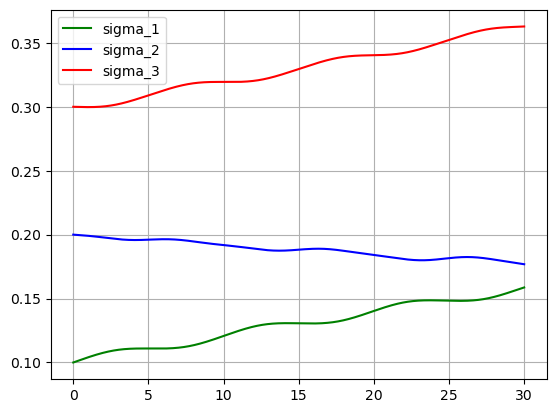

In [132]:


plt.plot(time_vector, mrp[0,:], 'g', label='sigma_1')
plt.plot(time_vector, mrp[1,:], 'b', label='sigma_2')
plt.plot(time_vector, mrp[2,:], 'r', label='sigma_3')
plt.legend()
plt.grid()



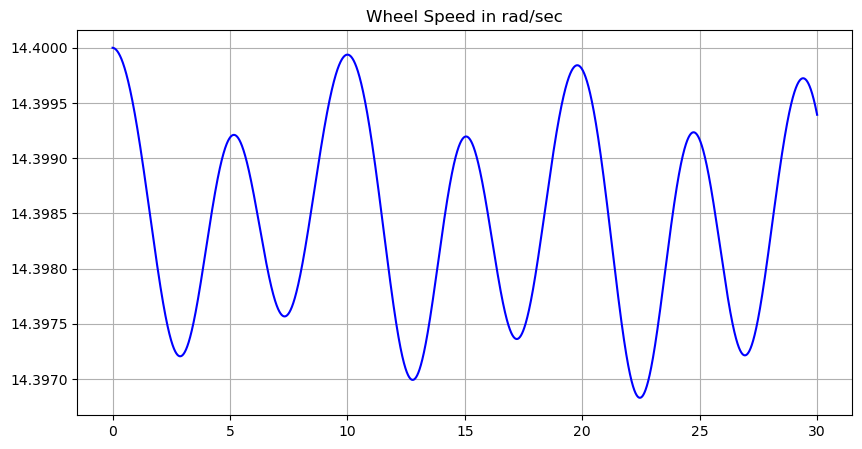

In [153]:
# generate a figure with 10 x 6 dimensions
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_title('Wheel Speed in rad/sec')
ax.plot(time_vector, wheel_speed, 'b')
ax.grid()

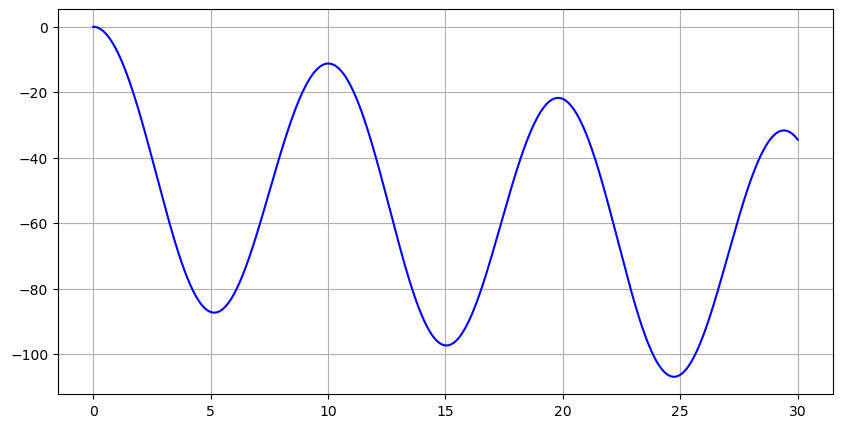

In [142]:
# generate a figure with 10 x 6 dimensions
fig, ax = plt.subplots(figsize=(10, 5))
ax.title('Gimbal Angle in deg')
ax.plot(time_vector, np.rad2deg(gimbal_angle), 'b')
ax.grid()

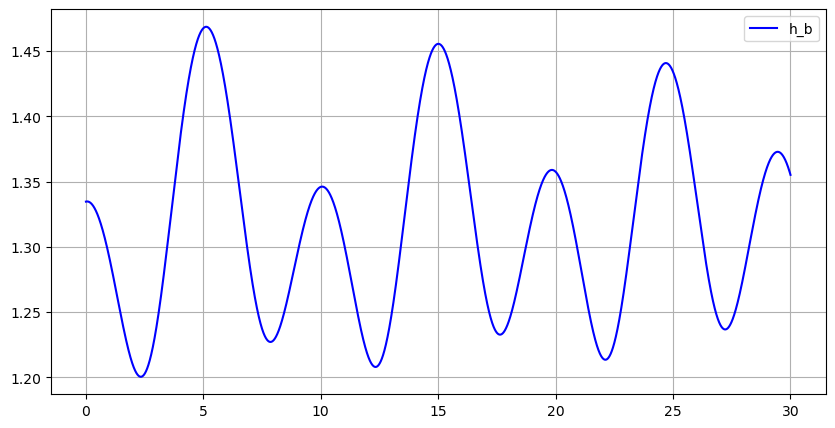

In [139]:
# generate a figure with 10 x 6 dimensions
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(time_vector, np.linalg.norm(ang_momentum_body, axis=0), 'b', label='h_b')
ax.legend()
ax.grid()

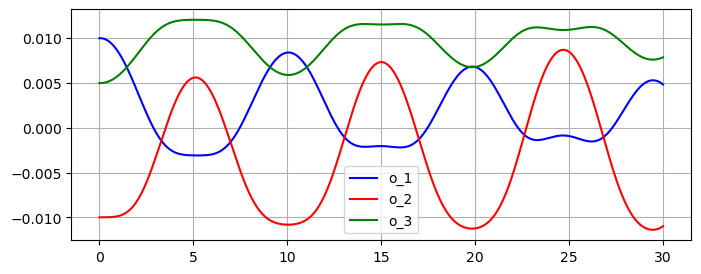

In [133]:
# generate a figure with 10 x 6 dimensions
fig, ax = plt.subplots(figsize=(8, 3))



ax.plot(time_vector, omega_bn[0,:], 'b', label='o_1')
ax.plot(time_vector, omega_bn[1,:], 'r', label='o_2')
ax.plot(time_vector, omega_bn[2,:], 'g', label='o_3')
ax.legend()
ax.grid()

## Single VSCMG Device Simulation

In [ ]:
def rigid_body_dynamics(x, u, t, inertia_matrix, external_torque):
    # Principal moments of inertia
    i_1, i_2, i_3 = np.diag(inertia_matrix)
    mrp_bn, omega_bn = x[:3], x[3:]
        
    mrp_bn_dot = 0.25 * b_matrix_mrp(mrp_bn) @ omega_bn
    omega_1_bn_dot = (i_2 - i_3) / i_1 * omega_bn[2] * omega_bn[1] + (u[0] + external_torque[0]) / i_1
    omega_2_bn_dot = (i_3 - i_1) / i_2 * omega_bn[0] * omega_bn[2] + (u[1] + external_torque[1]) / i_2
    omega_3_bn_dot = (i_1 - i_2) / i_3 * omega_bn[1] * omega_bn[0] + (u[2] + external_torque[2]) / i_3
    omega_bn_dot = np.array([omega_1_bn_dot, omega_2_bn_dot, omega_3_bn_dot])
    
    x_dot = np.insert(mrp_bn_dot, 3, omega_bn_dot, axis=0)
    return x_dot

def runge_kutta45(f, t, control, initial_state, **kwargs):
    
    X = np.zeros((6, len(t)))
    X[:,0] = initial_state
    
    relative_attitude = np.zeros((3, len(t)))

    u = np.zeros((3, len(t)))
    
    for i in range(0, len(t)-1):
        h = t[i+1] - t[i]
        x = X[:, i]
    
        # Calculate reference state
        mrp_rn = sigma_rn(t[i])
        omega_rn = omega_rn_func(t[i])
        omega_rn_dot = omega_rn_dot_func(t[i], h)
        
        # system state
        mrp_bn, omega_bn = x[:3], x[3:]
        
        # calculate relative state
        mrp_br = mrp_subtract(mrp_bn, mrp_rn)
        mrp_br_norm = norm(mrp_br)
        if mrp_br_norm > 1:
            mrp_br = -mrp_br / (mrp_br_norm**2)
            
        relative_attitude[:, i] = mrp_br
        
        # Convert all reference vectors to body frame components
        dcm_br = mrp_to_dcm(mrp_br)
        omega_rn_bframe = dcm_br @ omega_rn 
        omega_rn_dot_bframe = dcm_br @ omega_rn_dot
    
        ui = control(mrp_br, omega_bn, omega_rn_bframe, omega_rn_dot_bframe, inertia_matrix)
        
        k1 = h * f(x, ui, t[i], **kwargs)
        k2 = h * f(x + k1/2, ui, t[i] + h/2, **kwargs)
        k3 = h * f(x + k2/2, ui, t[i] + h/2, **kwargs)
        k4 = h * f(x + k3, ui, t[i] + h, **kwargs)
        
        new_state = X[:,i] + 1/6*(k1 + 2*k2 + 2*k3 + k4)
        new_mrp = new_state[:3]
        if norm(new_mrp) >= 1:
            new_state[:3] = -new_mrp / norm(new_mrp)**2
            
        X[:, i+1] = new_state
        u[:,i] = ui
        
    return X, u, relative_attitude

# Initial Conditions
omega_bn_0 = np.deg2rad([30,10,-20])
sigma_bn_0 = np.array([0.1,0.2,-0.1])

initial_state = np.insert(sigma_bn_0, 3, omega_bn_0, axis=0)
inertia_matrix = np.diag(np.array([100,75,80]))
external_torque = np.array([0,0,0])

# Time interval
h = 0.1
t0 = 0
tf = 100
t = np.linspace(t0, tf, int(tf/h)+1)


X, u, sigma_br = runge_kutta45(rigid_body_dynamics, t, stabilizing_control, initial_state,
                    inertia_matrix=inertia_matrix,
                    external_torque = external_torque)

In [82]:
import matplotlib.pyplot as plt

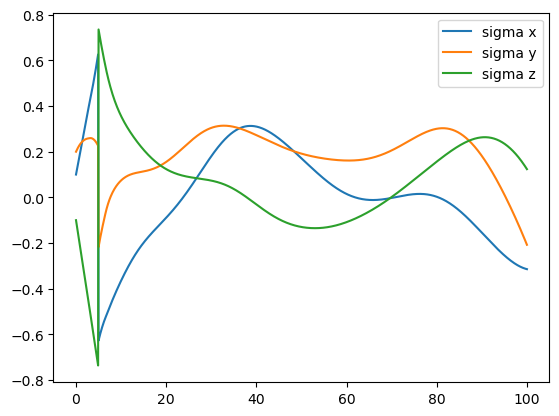

In [85]:
plt.plot(t, X[0, :], label='sigma x')
plt.plot(t, X[1, :], label='sigma y')
plt.plot(t, X[2, :], label='sigma z')
plt.legend()

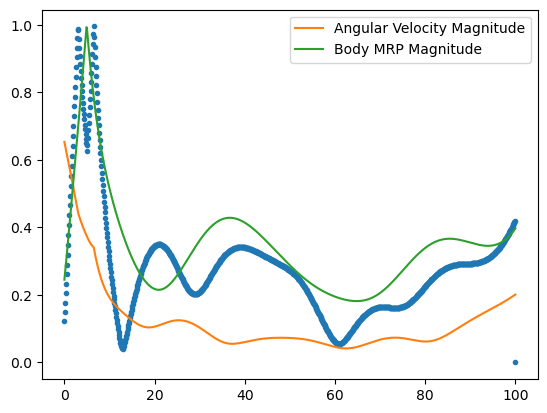

In [83]:
plt.plot(t, norm(sigma_br, axis=0), '.')
plt.plot(t, norm(X[3:,:], axis=0), label='Angular Velocity Magnitude')
plt.plot(t, norm(X[:3,:], axis=0), label='Body MRP Magnitude')
plt.legend()

In [69]:
sigma_br[:,150]

array([-0.12578455, -0.06868286, -0.07534889])

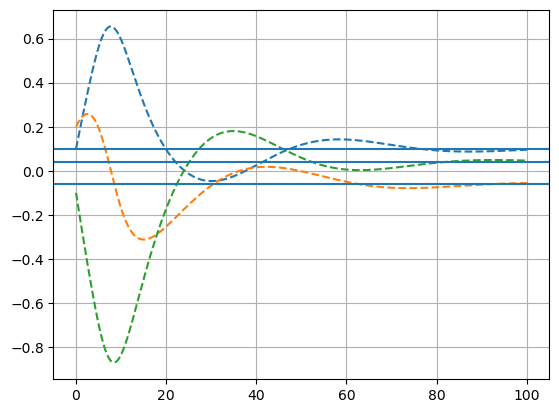

In [282]:
plt.plot(t, state[3,:], '--')
plt.plot(t, state[4,:],'--')
plt.plot(t, state[5,:],'--')
plt.grid()

# plt.plot(t, 0.2*np.sin(0.05 * t), 'r--')
# plt.plot(t, 0.3*np.cos(0.05 * t), 'b--')
# plt.plot(t, -0.3*np.sin(0.05 * t), 'g--')

plt.axhline(0.1)
plt.axhline(-0.06)
plt.axhline(0.04)

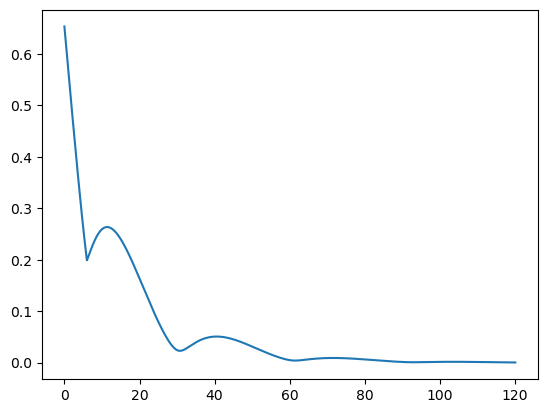

In [177]:
plt.plot(t, norm(state[:3,:], axis=0))

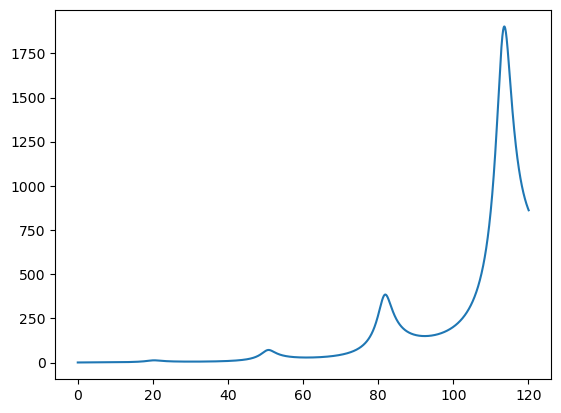

In [176]:
plt.plot(t, norm(state[3:,:], axis=0))

In [67]:
norm = np.linalg.norm
def mrp_sum(g1, g2):
    
    norm1 = norm(g1)
    norm2 = norm(g2)
    
    g_sum = ((1-norm1**2)*g2 +(1-norm2**2)*g1 - 2*np.cross(g1, g2)) / (1 + norm1**2 * norm2**2 - 2 * np.dot(g1, g2))
    return g_sum


def mrp_to_dcm(mrp_vector):
    
    identity = np.identity(3)
    mrp_cross_matrix = tilde(mrp_vector)
    norm_mrp = norm(mrp_vector)
    dcm = identity + (8 * mrp_cross_matrix @ mrp_cross_matrix - 4 * (1 - norm_mrp ** 2) * mrp_cross_matrix) / \
                     ((1 + norm_mrp ** 2) ** 2)
    return dcm
    
def runge_kutta45(f, initial_state, t):
    
    y = np.zeros((2, len(t)))
    y[:,0] = initial_state
    
    for i in range(0, len(t)-1):
        h = t[i+1] - t[i]
        k1 = h * f(y[:, i], t[i])
        k2 = h * f(y[:, i] + k1/2, t[i] + h/2)
        k3 = h * f(y[:, i] + k2/2, t[i] + h/2)
        k4 = h * f(y[:, i] + k3, t[i] + h)
        y[:,i+1] = y[:,i] + 1/6*(k1 + 2*k2 + 2*k3 + k4)
    return y

def state_space_derivative(x, t, inertia_matrix):
    """State space derivative definition.

    First three elements are the omegas, the following three are the MRPs"""

    # Identity matrix
    identity_matrix = np.identity(3)

    # Principal moments of inertia
    i_1 = inertia_matrix[0, 0]
    i_2 = inertia_matrix[1, 1]
    i_3 = inertia_matrix[2, 2]

    # Splitting the state space in omegas and modified rodrigues parameters (MRPs)
    omega_bn_vect = x[0:3]
    mrp_bn_vect = x[-3:]

    # Norm and cross product matrix of the MRPs BN
    mrp_bn_cross_matrix = tilde(mrp_bn_vect)
    mrp_bn_norm = np.linalg.norm(mrp_bn_vect)

    mrp_rn_vect, omega_rn_vect_rframe = mrp_and_omega_rn(t)

    omega_rn_dot_vect = omega_dot_rn(t, h)
    # TODO: the time step should be an input of the state_space_derivative function

    # MRPs BR and check their norm is not bigger than 1, otherwise the shadow set is consider
    mrp_br_vect = mrp_sum(-mrp_rn_vect, mrp_bn_vect)
    mrp_br_norm = np.linalg.norm(mrp_br_vect)
    if mrp_br_norm > 1:
        mrp_br_vect = -mrp_br_vect / (mrp_br_norm ** 2)

    # DCM_BR
    dcm_br = mrp_to_dcm(mrp_br_vect)

    # omega_rn in the b_frame
    omega_rn_vect = np.dot(dcm_br, omega_rn_vect_rframe)

    # omega_br
    omega_br_vect = omega_bn_vect - omega_rn_vect

    if t == 40:
        print("sigma_br norm at ", t, ": ", np.linalg.norm(mrp_br_vect))

    # Control vector
    k = 5
    p = 10
    omega_bn_cross_matrix = tilde(omega_bn_vect)
    u = - k * mrp_br_vect - p * np.dot(identity_matrix, omega_br_vect) + \
        np.dot(inertia_matrix, (omega_rn_dot_vect - np.cross(omega_bn_vect, omega_rn_vect))) + \
        omega_bn_cross_matrix.dot(inertia_matrix).dot(omega_bn_vect)

    # Computation of the MRPs kinematic differential equation and omegas differential equations
    mrp_bn_dot_vect = 0.25 * np.dot(((1 - mrp_bn_norm ** 2) * identity_matrix + 2 * mrp_bn_cross_matrix +
                                     2 * np.outer(mrp_bn_vect, mrp_bn_vect)), omega_bn_vect)
    omega_1_bn_dot = (i_2 - i_3) / i_1 * omega_bn_vect[2] * omega_bn_vect[1] + u[0] / i_1
    omega_2_bn_dot = (i_3 - i_1) / i_2 * omega_bn_vect[0] * omega_bn_vect[2] + u[1] / i_2
    omega_3_bn_dot = (i_1 - i_2) / i_3 * omega_bn_vect[1] * omega_bn_vect[0] + u[2] / i_3
    omega_bn_dot_vect = np.array([omega_1_bn_dot, omega_2_bn_dot, omega_3_bn_dot])

    # Assembly of the state space derivative vector as the three omegas_dot and teh three MRPs_dot
    x_dot = np.insert(omega_bn_dot_vect, 3, mrp_bn_dot_vect, axis=0)
    return x_dot


def sigma_rn(t):
    f = 0.05
    sig_rn = np.array([0.2 * np.sin(f * t), 0.3 * np.cos(f * t), -0.3 * np.sin(f * t)])
    return sig_rn


def sigma_rn_prime(t):
    f = 0.05
    sig_rn_prime = f * np.array([0.2 * np.cos(f * t), -0.3 * np.sin(f * t), -0.3 * np.cos(f * t)])
    return sig_rn_prime


def mrp_and_omega_rn(t):
    identity_mat = np.identity(3)
    # MRPs RN (and derivative)
    mrp_rn = sigma_rn(t)
    mrp_rn_norm = np.linalg.norm(mrp_rn)
    mrp_rn_cross_matrix = tilde(mrp_rn)
    mrp_rn_dot = sigma_rn_prime(t)

    # B matrix of the MRPs kinematic differential equation (Eq. 3.155)
    b_matrix = 0.25 * ((1 - mrp_rn_norm ** 2) * identity_mat + 2 * mrp_rn_cross_matrix + 2 * np.outer(mrp_rn, mrp_rn))

    # omega_rn in r-frame, computed as (Eq. 3.158)
    omega_rn_rframe = 4 / ((1 + mrp_rn_norm ** 2) ** 2) * np.dot(b_matrix.transpose(), mrp_rn_dot)

    return mrp_rn, omega_rn_rframe


def omega_dot_rn(t, tstep):
    _, omega_rn_before = mrp_and_omega_rn(t-tstep)
    _, omega_rn_after = mrp_and_omega_rn(t+tstep)
    omega_rn_dot = (omega_rn_after - omega_rn_before) / (2 * tstep)
    return omega_rn_dot


# Initial conditions
omega_bn_zero = np.deg2rad(np.array([30, 10, -20]))
sigma_bn_zero = np.array([0.1, 0.2, -0.1])
state_vector_initial = np.insert(omega_bn_zero, 3, sigma_bn_zero, axis=0)

# Inertia matrix
inertia_mat = np.diag(np.array([100, 75, 80]))

# Time interval
h = 0.01
initial_t = 0
final_t = 40
t_vect, omega = runge_kutta(state_space_derivative, initial_t, final_t, state_vector_initial, h, inertia_mat)


    

In [51]:
inertia = np.array([
    [100,0,0],
    [0,75,0],
    [0,0,80]
])

sigma0 = MRP(0.1,0.2,-0.1)
omega0 = np.deg2rad(np.array([30,10,-20]))

K = 5
P = 10 * np.eye(3)
L = 0


t0, tf = 0, 30
step = 0.01
length = int(round(tf-t0)/step)
time = np.linspace(t0, tf+step, length)



results = []

control_history = []
sigma = sigma0
omega = omega0
omega_r = np.array([0,0,0])
for t in time:
    
    gyroscopic = tilde(omega) @ (inertia@omega)
    control = -K*sigma.vector - P@omega + inertia@(omega_r - tilde(omega)@omega_r) + gyroscopic - L
    
    omega_dot = np.linalg.inv(inertia) @ (-gyroscopic + control + L)
    omega += omega_dot * step
    sigma_dot = 0.25 * sigma.b_matrix @ omega
    
    sigma_new = sigma.vector + sigma_dot
    sigma = MRP(*sigma_new)

print(sigma)
    
    

MRP<[nan nan nan]>


/var/folders/fr/6_7v365d1sd712jpqdkltk4w0000gn/T/ipykernel_2959/221276785.py:35: RuntimeWarning: overflow encountered in matmul
  sigma_dot = 0.25 * sigma.b_matrix @ omega
/var/folders/fr/6_7v365d1sd712jpqdkltk4w0000gn/T/ipykernel_2959/221276785.py:33: RuntimeWarning: invalid value encountered in matmul
  omega_dot = np.linalg.inv(inertia) @ (-gyroscopic + control + L)
/Users/sam/Documents/optimization/refactor/mrp.py:29: RuntimeWarning: invalid value encountered in scalar add
  [1-norm_2+2*s1**2, 2*(s1*s2-s3), 2*(s1*s3+s2)],
/Users/sam/Documents/optimization/refactor/mrp.py:29: RuntimeWarning: invalid value encountered in scalar subtract
  [1-norm_2+2*s1**2, 2*(s1*s2-s3), 2*(s1*s3+s2)],
/Users/sam/Documents/optimization/refactor/mrp.py:30: RuntimeWarning: invalid value encountered in scalar add
  [2*(s2*s1+s3), 1-norm_2+2*s2**2, 2*(s2*s3-s1)],
/Users/sam/Documents/optimization/refactor/mrp.py:30: RuntimeWarning: invalid value encountered in scalar subtract
  [2*(s2*s1+s3), 1-norm_2+2*

In [284]:
np.sqrt(5)*np.sqrt([100, 75, 80])

array([22.36067977, 19.36491673, 20.        ])

In [ ]:
def state_derivatives(X, t, time_step, inertia_matrix, external_torque, sigma_history, initial_state):
    
    identity = np.identity(3)
    
    # Principal moments of inertia
    i_1 = inertia_matrix[0, 0]
    i_2 = inertia_matrix[1, 1]
    i_3 = inertia_matrix[2, 2]
    
    omega_bn = X[0:3]
    mrp_bn = X[3:]
    
    mrp_rn, omega_rn_rframe = mrp_omega_rn(t)
    omega_rn_dot_vect = omega_rn_dot(t, time_step)
    
    mrp_br = mrp_sum(-mrp_rn, mrp_bn)
    mrp_br_norm = norm(mrp_br)
    if mrp_br_norm > 1:
        mrp_br = -mrp_br / (mrp_br_norm**2)
        
    dcm_br = mrp_to_dcm(mrp_br)
    omega_rn = dcm_br @ omega_rn_rframe
    omega_br = omega_bn - omega_rn
    omega_bn_cross = tilde(omega_bn)
    
    if np.abs(t-45) < 1e-2:
        print('*'*50)
        print("sigma_br norm at", t, ": ", norm(mrp_br))
        print("omega_br norm at", t, ": ", norm(omega_br))
    
    # Control Vector
    K = 5
    P = 10
    Ki = 0.005

    sigma_history[:, int(t/time_step)] = mrp_br
    
    # u = -K*mrp_bn - P*omega_bn + omega_bn_cross @ inertia_matrix @ omega_bn
    
    omega_bn_0 = initial_state[:3]
    _, omega_rn_0 = mrp_omega_rn(0)
    omega_br_0 = omega_bn_0 - omega_rn_0
    
    z = K * time_step * np.sum(sigma_history, axis=1) + inertia_matrix @ (omega_br - omega_br_0)
            
    u = -K*mrp_br - P*omega_br + inertia_matrix @ (omega_rn_dot_vect - omega_bn_cross @ omega_rn) \
        + omega_bn_cross @ inertia_matrix @ omega_bn - P*Ki*z
        
    # u = -K*mrp_br - P*omega_br
    
    mrp_bn_dot = 0.25 * b_matrix_mrp(mrp_bn) @ omega_bn
    omega_1_bn_dot = (i_2 - i_3) / i_1 * omega_bn[2] * omega_bn[1] + (u[0] + external_torque[0]) / i_1
    omega_2_bn_dot = (i_3 - i_1) / i_2 * omega_bn[0] * omega_bn[2] + (u[1] + external_torque[1]) / i_2
    omega_3_bn_dot = (i_1 - i_2) / i_3 * omega_bn[1] * omega_bn[0] + (u[2] + external_torque[2]) / i_3
    omega_bn_dot = np.array([omega_1_bn_dot, omega_2_bn_dot, omega_3_bn_dot])
    
    x_dot = np.insert(omega_bn_dot, 3, mrp_bn_dot, axis=0)
    return x_dot

def sigma_rn(t):

    return np.array([0,0,0])
    
def sigma_rn_dot(t):

    return np.array([0,0,0])

def mrp_omega_rn(t):
    
    mrp_rn = sigma_rn(t)
    mrp_rn_norm = norm(mrp_rn)
    b_matrix_rn = b_matrix_mrp(mrp_rn)
    b_matrix_rn_inv = np.transpose(b_matrix_rn) / (1 + mrp_rn_norm**2)
    
    omega_rn = 4 * b_matrix_rn_inv @ sigma_rn_dot(t)
    
    return mrp_rn, omega_rn

def omega_rn_dot(t, time_step):
    
    _, omega_rn_before = mrp_omega_rn(t - time_step)
    _, omega_rn_after = mrp_omega_rn(t + time_step)
    omega_rn_dot = (omega_rn_after - omega_rn_before) / (2 * time_step)
    return omega_rn_dot
    
    
    


def runge_kutta45(f, t, initial_state, **kwargs):
    
    X = np.zeros((6, len(t)))
    X[:,0] = initial_state
    
    for i in range(0, len(t)-1):
        h = t[i+1] - t[i]
        k1 = h * f(X[:, i], t[i], initial_state=initial_state, **kwargs)
        k2 = h * f(X[:, i] + k1/2, t[i] + h/2, initial_state=initial_state, **kwargs)
        k3 = h * f(X[:, i] + k2/2, t[i] + h/2, initial_state=initial_state, **kwargs)
        k4 = h * f(X[:, i] + k3, t[i] + h, initial_state=initial_state, **kwargs)
        X[:,i+1] = X[:,i] + 1/6*(k1 + 2*k2 + 2*k3 + k4)
    return X

# Initial Conditions
omega_bn_0 = np.deg2rad([3,1,-2])
sigma_bn_0 = np.array([0.1,0.2,-0.1])


initial_state = np.insert(omega_bn_0, 3, sigma_bn_0, axis=0)

inertia_matrix = np.diag(np.array([100,75,80]))

external_torque = np.array([0,0,0])

# Time interval
h = 0.03
t0 = 0
tf = 100
t = np.linspace(t0, tf+h, int(tf/h))
sigmas = np.zeros((3, len(t)))
sigmas[:,0] = sigma_bn_0

state = runge_kutta45(state_derivatives, t,
                    initial_state,
                    time_step=h,
                    inertia_matrix=inertia_matrix,
                    external_torque = external_torque)
